In [1]:
import getpass
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
import chromadb
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

load_dotenv()

model = "gpt-3.5-turbo"

llm = ChatOpenAI(temperature=0.5, model=model, max_tokens=4096)
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
from langchain_chroma import Chroma
os.environ["LANGSMITH_PROJECT"] = "data-chunking-pdf"

chroma_client = chromadb.HttpClient(host='localhost', port=8000)
print(chroma_client.heartbeat())

vector_store = Chroma(
    collection_name="llm-rag-ai",
    embedding_function=embeddings,
    client=chroma_client
)
retriever = vector_store.as_retriever()


1739448163391841638


In [3]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

template = """
**Context**: {context}
You are an AI assistant specialized in answering questions about Artificial Intelligence (AI), Large Language Models (LLMs), Retrieval-Augmented Generation (RAG), and Python programming. Your task is to provide clear, accurate, and concise explanations. If the question is outside your scope, politely inform the user.

**User Question**: {question}

**Your Response**:
1. Provide a clear and structured answer.
2. Include examples, code snippets, or analogies if applicable.
3. Do not include any additional explanations or context.
4. Do not hallucinate.
"""
prompt_template = ChatPromptTemplate([
    ("system", template),
    ("user", "{question}")
])

In [4]:
question = "provide me a good example of rag applied to real-state"

In [17]:
# from langchain_core.runnables import RunnablePassthrough
# from langchain_core.output_parsers import StrOutputParser
#
# rag_chain = (
#         {"context": retriever, "question": RunnablePassthrough()}
#         | prompt_template
#         | llm
#         | StrOutputParser()
# )
#
# response = rag_chain.invoke(question)
# print(response)

In [18]:
from langchain_core.documents import Document
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"],k=3)
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt_template.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [19]:
response = graph.invoke({"question": question})
print(response["answer"])

A good example of Retrieval-Augmented Generation (RAG) applied to real estate is in generating property valuations and recommendations. Here's how it works:

1. **Data Collection**: The RAG model collects and retrieves data from various sources such as historical housing prices, local market trends, demographic information, and economic indicators.

2. **Analysis and Generation**: The model analyzes this data using machine learning algorithms to understand patterns and trends. It then generates accurate property valuations and recommendations.

3. **Personalized Recommendations**: Real estate agents can input specific property details or client preferences into the RAG model, which will generate tailored recommendations and valuations. This helps agents make informed decisions and provide better service to clients.

This application enhances the decision-making process in real estate by providing data-driven insights and reducing the reliance on subjective judgment.


# Chat History

In [5]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [6]:
from langchain_core.messages import SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}


# Build graph
graph_builder = StateGraph(MessagesState)

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

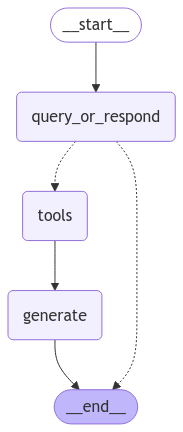

In [7]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [17]:
input_message = "im juan"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

im juan
================================== Ai Message ==================================

Hello Juan! How can I assist you today?


In [11]:
chat_history = graph.get_state(config).values["messages"]
for message in chat_history:
    message.pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hi there! How can I assist you today?
================================ Human Message =================================

who are you?
================================== Ai Message ==================================

I am an AI assistant here to help you with any questions or tasks you may have. How can I assist you today?
